In [1]:
# Core YOLO
from ultralytics import YOLO  # main YOLOv8 library

# Basic utilities
import os
import shutil
import glob
import random

# Numerical + Data Handling
import numpy as np
import pandas as pd

# Visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Progress bar
from tqdm import tqdm

# System checks
import torch
from warnings import filterwarnings
filterwarnings("ignore")

In [7]:
from ultralytics.data.utils import check_det_dataset

dataset_info = check_det_dataset("F:/Research/farmland_seg_v4/data.yaml")
print(dataset_info)


{'train': 'F:\\Research\\farmland_seg_v4\\dataset\\train\\images', 'val': 'F:\\Research\\farmland_seg_v4\\dataset\\valid\\images', 'test': 'F:\\Research\\farmland_seg_v4\\dataset\\test\\images', 'nc': 1, 'names': {0: 'Indian-Farms'}, 'yaml_file': 'F:/Research/farmland_seg_v4/data.yaml', 'path': WindowsPath('F:/Research/farmland_seg_v4')}


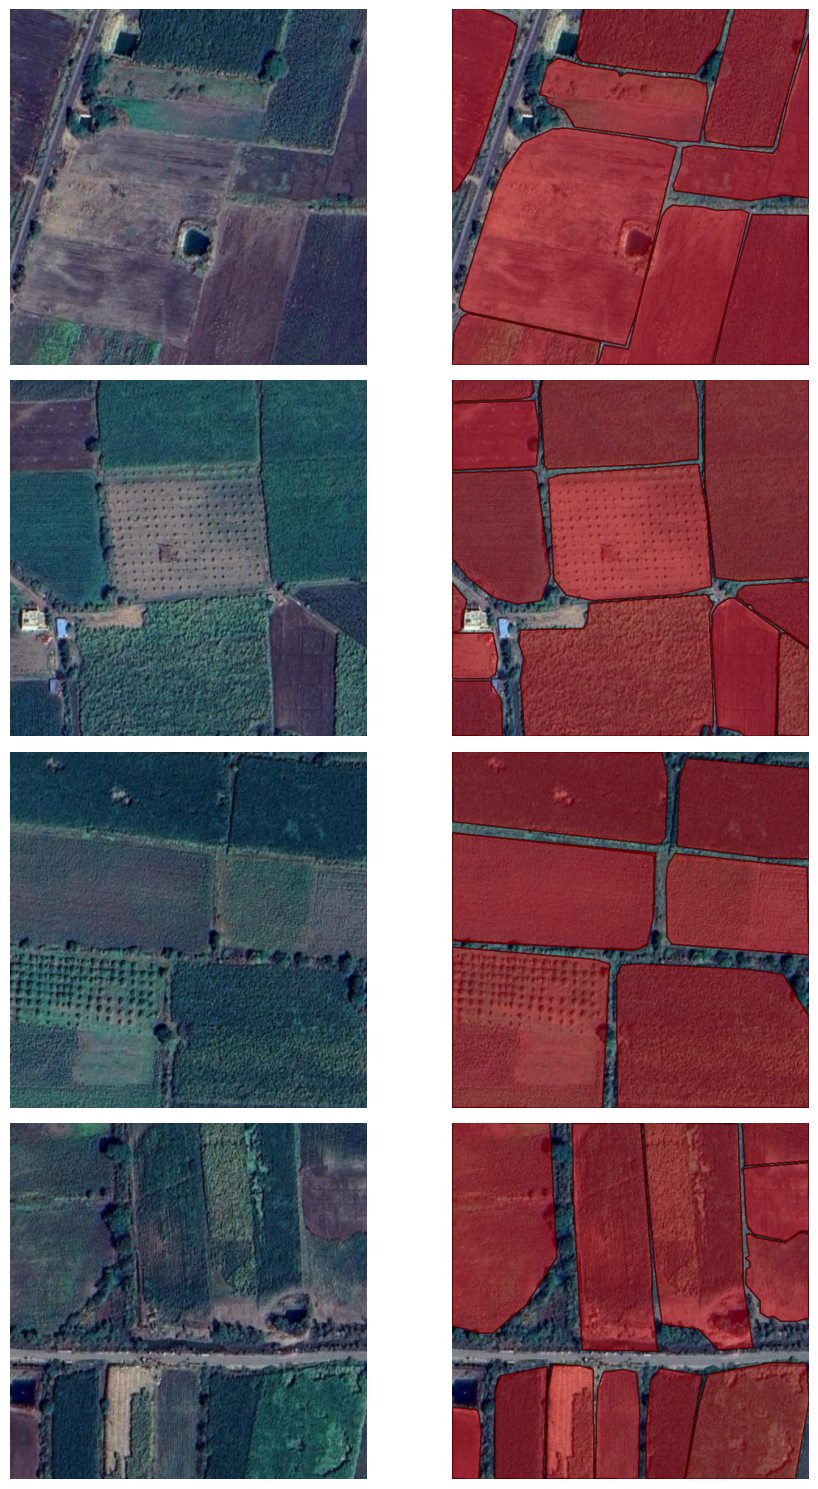

In [13]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# Paths
image_dir = r"F:\Research\farmland_seg_v4\dataset\train\images"
label_dir = r"F:\Research\farmland_seg_v4\dataset\train\labels"

# Get 4 random images
image_files = random.sample(glob(os.path.join(image_dir, "*.jpg")), 4)

def load_yolo_segmentation(label_path, img_w, img_h):
    masks = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls, coords = parts[0], parts[1:]
                coords = np.array(coords, dtype=float).reshape(-1, 2)
                coords[:, 0] *= img_w
                coords[:, 1] *= img_h
                masks.append(coords.astype(int))
    return masks

# Plot
fig, axes = plt.subplots(len(image_files), 2, figsize=(10, 15))

for i, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Load corresponding label
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt"))
    masks = load_yolo_segmentation(label_path, w, h)

    # Create copy for annotation
    annotated = img.copy()
    overlay = annotated.copy()

    for mask in masks:
        cv2.fillPoly(overlay, [mask], color=(255, 0, 0))  # red mask
        cv2.polylines(annotated, [mask], isClosed=True, color=(0, 0, 0), thickness=2)  # black outline

    # Blend with transparency
    alpha = 0.4  # transparency factor
    annotated = cv2.addWeighted(overlay, alpha, annotated, 1 - alpha, 0)

    # Show raw + annotated side by side
    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(annotated)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [14]:
from ultralytics import YOLO

# Load pre-trained YOLOv8 small segmentation model
model = YOLO("yolov8s-seg.pt")

model.train(
    data="F:/Research/farmland_seg_v4/data.yaml",
    epochs=10,          # longer training for better convergence
    imgsz=640,           # balanced resolution
    batch=8,             # fits in 4GB VRAM
    workers=2,           # Ryzen 5 laptop safe
    device=0,            # use GPU
    patience=20,         # early stopping
    augment=True,        # enable augmentations
    cos_lr=True,         # cosine LR scheduling
    lr0=0.001,           # initial learning rate
    optimizer="AdamW",   # better optimizer for segmentation
)


100%|██████████| 22.8M/22.8M [00:12<00:00, 1.93MB/s]


New https://pypi.org/project/ultralytics/8.3.189 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.10 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=F:/Research/farmland_seg_v4/data.yaml, epochs=10, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

100%|██████████| 6.25M/6.25M [00:01<00:00, 4.91MB/s]


AMP: checks passed 


train: Scanning F:\Research\farmland_seg_v4\dataset\train\labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

train: WARNING  F:\Research\farmland_seg_v4\dataset\train\images\tile_11_8_png.rf.a9640cca3594ab73c16b4130c9f2cb30.jpg: 1 duplicate labels removed
train: WARNING  F:\Research\farmland_seg_v4\dataset\train\images\tile_8_12_png.rf.c2b850aa6622a07815b8f2c740e0ee63.jpg: 1 duplicate labels removed



val: Scanning F:\Research\farmland_seg_v4\dataset\valid\labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]


Plotting labels to f:\Research\farmland_seg_v4\runs\segment\train\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 72 weight(decay=0.0), 83 weight(decay=0.0005), 82 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to f:\Research\farmland_seg_v4\runs\segment\train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.76G        nan        nan        nan        nan         50        640: 100%|██████████| 32/32 [01:18<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10       2.8G        nan        nan        nan        nan         54        640: 100%|██████████| 32/32 [01:03<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.71G        nan        nan        nan        nan         62        640: 100%|██████████| 32/32 [01:06<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.76G        nan        nan        nan        nan         55        640: 100%|██████████| 32/32 [01:17<00:00,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.78G        nan        nan        nan        nan         57        640: 100%|██████████| 32/32 [01:23<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.72G        nan        nan        nan        nan         54        640: 100%|██████████| 32/32 [01:39<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.75G        nan        nan        nan        nan         50        640: 100%|██████████| 32/32 [01:31<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.72s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.75G        nan        nan        nan        nan         67        640: 100%|██████████| 32/32 [01:28<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.76G        nan        nan        nan        nan         51        640: 100%|██████████| 32/32 [01:35<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]

                   all         44        380          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.77G        nan        nan        nan        nan         61        640: 100%|██████████| 32/32 [01:35<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.59s/it]

                   all         44        380          0          0          0          0          0          0          0          0



10 epochs completed in 0.259 hours.
Optimizer stripped from f:\Research\farmland_seg_v4\runs\segment\train\weights\last.pt, 21.3MB
Optimizer stripped from f:\Research\farmland_seg_v4\runs\segment\train\weights\best.pt, 21.3MB

Validating f:\Research\farmland_seg_v4\runs\segment\train\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.10 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8s-seg summary (fused): 213 layers, 10,482,067 parameters, 0 gradients, 34.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:02<00:04,  2.24s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:05<00:02,  2.69s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

                   all         44        380          0          0          0          0          0          0          0          0


Speed: 1.4ms preprocess, 95.6ms inference, 0.2ms loss, 12.5ms postprocess per image
Results saved to f:\Research\farmland_seg_v4\runs\segment\train


AttributeError: 'SegmentMetrics' object has no attribute 'curves_results'. See valid attributes below.

    Calculates and aggregates detection and segmentation metrics over a given set of classes.

    Args:
        save_dir (Path): Path to the directory where the output plots should be saved. Default is the current directory.
        plot (bool): Whether to save the detection and segmentation plots. Default is False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (list): List of class names. Default is an empty list.

    Attributes:
        save_dir (Path): Path to the directory where the output plots should be saved.
        plot (bool): Whether to save the detection and segmentation plots.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (list): List of class names.
        box (Metric): An instance of the Metric class to calculate box detection metrics.
        seg (Metric): An instance of the Metric class to calculate mask segmentation metrics.
        speed (dict): Dictionary to store the time taken in different phases of inference.

    Methods:
        process(tp_m, tp_b, conf, pred_cls, target_cls): Processes metrics over the given set of predictions.
        mean_results(): Returns the mean of the detection and segmentation metrics over all the classes.
        class_result(i): Returns the detection and segmentation metrics of class `i`.
        maps: Returns the mean Average Precision (mAP) scores for IoU thresholds ranging from 0.50 to 0.95.
        fitness: Returns the fitness scores, which are a single weighted combination of metrics.
        ap_class_index: Returns the list of indices of classes used to compute Average Precision (AP).
        results_dict: Returns the dictionary containing all the detection and segmentation metrics and fitness score.
    

In [15]:
metrics = model.val()
print("Segmentation mAP50:", metrics.seg.map50)
print("Segmentation mAP50-95:", metrics.seg.map)


Ultralytics 8.3.0  Python-3.12.10 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8s-seg summary (fused): 213 layers, 10,482,067 parameters, 0 gradients, 34.8 GFLOPs


val: Scanning F:\Research\farmland_seg_v4\dataset\valid\labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  17%|█▋        | 1/6 [00:11<00:59, 11.85s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 2/6 [00:13<00:22,  5.68s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:15<00:12,  4.13s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 4/6 [00:17<00:06,  3.32s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  83%|████████▎ | 5/6 [00:19<00:02,  2.74s/it]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:21<00:00,  3.64s/it]

                   all         44        380          0          0          0          0          0          0          0          0


Speed: 16.4ms preprocess, 147.7ms inference, 0.7ms loss, 10.7ms postprocess per image
Results saved to f:\Research\farmland_seg_v4\runs\segment\train2
Segmentation mAP50: 0.0
Segmentation mAP50-95: 0.0


In [19]:
results = model.predict("F:/Research/farmland_seg_v4/dataset/test/images", save=True, imgsz=640, conf=0.25)
for r in results[:4]:
    r.show()  # show with masks



WARNING  Model does not support 'augment=True', reverting to single-scale prediction.
image 1/22 F:\Research\farmland_seg_v4\dataset\test\images\tile_10_0_png.rf.ef1f880da63b5528a22bffbe10c5e3cb.jpg: 640x640 (no detections), 271.3ms
WARNING  Model does not support 'augment=True', reverting to single-scale prediction.
image 2/22 F:\Research\farmland_seg_v4\dataset\test\images\tile_11_2_png.rf.4846925cd4ad8c4d2c8aea5a11baf3db.jpg: 640x640 (no detections), 29.5ms
WARNING  Model does not support 'augment=True', reverting to single-scale prediction.
image 3/22 F:\Research\farmland_seg_v4\dataset\test\images\tile_13_1_png.rf.c9dede2c95290824c1335764ce84b187.jpg: 640x640 (no detections), 30.8ms
WARNING  Model does not support 'augment=True', reverting to single-scale prediction.
image 4/22 F:\Research\farmland_seg_v4\dataset\test\images\tile_13_3_png.rf.4a3920095b9fec1bdc8937d3b19b97cc.jpg: 640x640 (no detections), 29.3ms
WARNING  Model does not support 'augment=True', reverting to single-sc

In [29]:
from ultralytics import YOLO

# Load your trained segmentation model
model = YOLO(r"F:/Research/farmland_seg_v4/runs/segment/train/weights/best.pt")


In [32]:
from ultralytics import YOLO

# Load the trained segmentation model
model = YOLO(r"F:/Research/farmland_seg_v4/runs/segment/train/weights/best.pt")

# Training image path
img_path = r"F:/Research/farmland_seg_v4/dataset/train/images/tile_0_8_png.rf.8c889f957c6730744d01d84870c7056f.jpg"

# Run inference on the training image
results = model.predict(img_path, imgsz=640, conf=0.1, save=False)  # lower conf for weak predictions

# Get the first result
result = results[0]

# Check if masks were predicted
if hasattr(result, "masks") and result.masks is not None and len(result.masks.xy) > 0:
    print("Masks predicted!")
    result.show()  # Display the image with masks
    result.save(save_dir=r"F:/Research/farmland_seg_v4/output")  # Save masked image
else:
    print("No masks predicted. Model may still be undertrained.")



image 1/1 F:\Research\farmland_seg_v4\dataset\train\images\tile_0_8_png.rf.8c889f957c6730744d01d84870c7056f.jpg: 640x640 (no detections), 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
No masks predicted. Model may still be undertrained.
